# Train, tune, and deploy a custom ML model using the Time Series Classification (InceptionTime) Algorithm from AWS Marketplace

The [Time Series Classification (Inception) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-omz7rumnllmla) performs time series classification with the InceptionTime model. It implements both training and inference from CSV data and supports both CPU and GPU instances. The training and inference Docker images were built by extending the PyTorch 2.1.0 Python 3.10 SageMaker containers. 

**Model Overview**

InceptionTime is an ensemble model. 
Each model in the ensemble has the same architecture and uses the same hyperparameters.
The only difference between the models is in the initial values of the weights, which are sampled from the Glorot uniform distribution.

Each model consists of a stack of blocks, where each block includes three convolutional layers with kernel sizes of 10, 20 and 40 and a max pooling layer.
The block input is processed by the four layers in parallel, and the four outputs are concatenated before being passed to a batch normalization layer followed by a ReLU activation. 

A residual connection is applied between the input time series and the output of the second block, and after that between every three blocks. 
The residual connection processes the inputs using an additional convolutional layer with a kernel size of 1 followed by a batch normalization layer.
The processed inputs are then added to the output, which is transformed by a ReLU activation.

The output is passed to an average pooling layer which removes the time dimension, and then to a final linear layer.

At inference time, the class probabilities predicted by the different models are averaged in order to obtain 
a unique predicted probability and, therefore, a unique predicted label, for each class.

<img src=https://fg-research-assets.s3.eu-west-1.amazonaws.com/inception-time-diagram.png style="width:80%;margin-top:30px;margin-bottom:20px"/>

*InceptionTime architecture (source: [doi: 10.1007/s10618-020-00710-y](https://doi.org/10.1007/s10618-020-00710-y))*

**Model Resources**

- **Paper:** [InceptionTime: Finding AlexNet for time series classification](https://doi.org/10.1007/s10618-020-00710-y).

This sample notebook shows you how to train a custom ML model using the [Time Series Classification (Inception) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-omz7rumnllmla).

**Note: This is a reference notebook and it cannot run unless you make the changes suggested in the notebook.**

## Pre-requisites
1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Classification (Inception) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-omz7rumnllmla).

## Contents
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
1. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	1. [Configure and visualize train and test dataset](#B.-Configure-and-visualize-train-and-test-dataset)
	1. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
1. [Train a machine learning model](#3:-Train-a-machine-learning-model)
	1. [Set up environment](#3.1-Set-up-environment)
	1. [Train a model](#3.2-Train-a-model)
1. [Deploy model and verify results](#4:-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
    1. [Create input payload](#B.-Create-input-payload)
    1. [Perform real-time inference](#C.-Perform-real-time-inference)
    1. [Visualize output](#D.-Visualize-output)
    1. [Calculate relevant metrics](#E.-Calculate-relevant-metrics)
    1. [Delete the endpoint](#F.-Delete-the-endpoint)
1. [Tune your model! (optional)](#5:-Tune-your-model!-(optional))
	1. [Tuning Guidelines](#A.-Tuning-Guidelines)
	1. [Define Tuning configuration](#B.-Define-Tuning-configuration)
	1. [Run a model tuning job](#C.-Run-a-model-tuning-job)
1. [Perform Batch inference](#6.-Perform-Batch-inference)
1. [Clean-up](#7.-Clean-up)
	1. [Delete the model](#A.-Delete-the-model)
	1. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))


## Usage instructions
You can run this notebook one cell at a time (by using Shift+Enter for running a cell).

## 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
# SageMaker algorithm ARN, replace the placeholder below with your AWS Marketplace ARN
algo_arn = "arn:aws:sagemaker:<...>"

## 2. Prepare dataset

In [2]:
import io
import datetime
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# SageMaker session
sagemaker_session = sagemaker.Session()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

### A. Dataset format expected by the algorithm

The training and validation datasets should be provided as CSV files. The column names of the class labels should 
start with `"y"` (e.g. `"y1"`, `"y2"`, ...), while the column names of the time series values should start with 
`"x"` (e.g. `"x1"`, `"x2"`, ...). 

The CSV file should contain unique sample identifiers in a column named `"sample"`, and unique feature identifiers 
in a column named `"feature"`. The feature identifiers are used to determine the different dimensions of multivariate 
time series. When using univariate time series, the feature identifiers can be set to a constant value. 

All the time series should have the same length and the same number of dimensions, and should not contain missing values.
The time series are scaled internally by the algorithm, there is no need to scale the time series beforehand.

You can find more information about dataset format in the **Usage Information** section of the algorithm listing page.

### B. Configure and visualize train and test dataset

The sample data provided in the algorithm's [GitHub repository](https://github.com/fg-research/inception-time-sagemaker) consists of three classes of artificially generated time series. Each time series has 5 dimensions and has length 100. The training dataset contains 240 samples, while the validation and test datasets contain 30 samples.

**Training dataset:**

In [4]:
training_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/inception-time-sagemaker/master/data/training/train.csv",
    index_col=None
)

In [5]:
training_dataset.head(10)

,sample,feature,y_1,y_2,y_3,x_1,x_2,x_3,x_4,x_5,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
0,1,1,0.0,0.0,1.0,-1.067482,-23.902732,0.268229,41.150126,48.880430,...,-10.966392,-0.661668,37.584867,45.444021,41.367410,18.263618,-2.807527,26.736408,22.658461,-0.646699
1,1,2,0.0,0.0,1.0,-11.467404,-12.261190,1.715410,35.551901,50.578553,...,-25.397056,5.769006,33.273985,54.899437,41.522112,18.870155,21.275493,14.048938,26.705180,6.591831
2,1,3,0.0,0.0,1.0,2.656632,-16.399746,-8.801383,36.532933,52.172514,...,-17.092312,1.317538,29.178137,58.374928,44.023392,25.345110,6.190895,34.084982,23.893237,2.576072
3,1,4,0.0,0.0,1.0,14.295695,-15.519053,9.659188,31.032674,52.982737,...,-15.232396,1.775889,46.506526,53.733480,47.268343,10.833302,12.362575,26.509150,19.230290,5.559620
4,1,5,0.0,0.0,1.0,1.194385,-12.946374,-2.213884,32.733920,53.919836,...,-13.622402,10.090314,37.017410,63.878813,39.977918,17.651468,6.074000,16.865884,20.409386,2.827499
5,2,1,0.0,1.0,0.0,23.967610,-2.498054,7.646263,31.827709,39.506019,...,7.537039,2.532938,33.626324,45.395938,14.950317,-1.572886,21.466918,30.847165,38.711919,20.539679
6,2,2,0.0,1.0,0.0,19.141719,4.314717,11.141609,28.885701,37.722752,...,-0.959701,21.374602,33.110142,42.853366,32.691238,0.107300,8.689436,27.298583,39.171966,3.988861
7,2,3,0.0,1.0,0.0,25.586182,-1.393232,3.161969,37.739791,42.724398,...,8.036493,5.363397,37.949917,45.290684,18.941122,5.035708,10.059634,26.387839,42.684220,27.748361
8,2,4,0.0,1.0,0.0,10.558819,0.462410,6.881069,34.746428,33.202336,...,1.803490,-6.736961,28.692451,48.010535,28.540000,8.057161,-10.850183,38.054042,40.078222,35.431656
9,2,5,0.0,1.0,0.0,17.862240,8.078772,2.578236,25.590297,43.714223,...,5.029263,7.422092,28.449374,38.237586,22.224526,0.759256,10.665938,32.100517,39.108438,21.617172


In [6]:
training_dataset.shape

(1200, 105)

In [7]:
training_dataset["sample"].nunique()

240

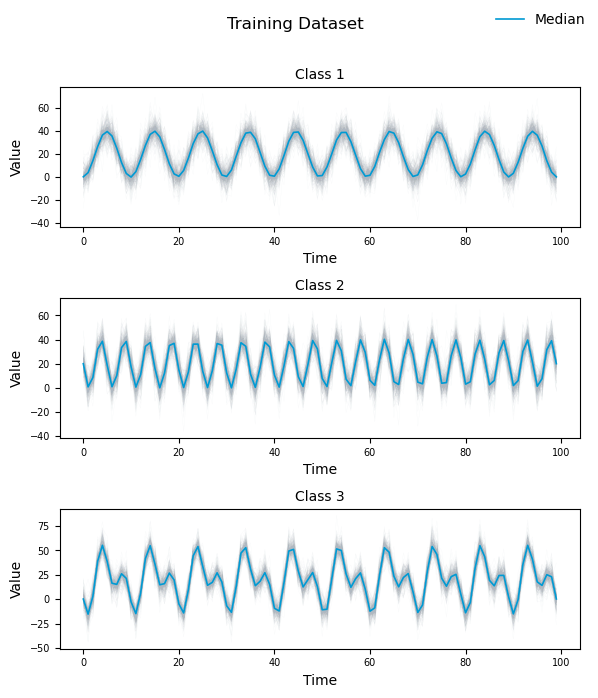

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 7))
for i in range(3):
    axs[i].plot(training_dataset[training_dataset[f"y_{i + 1}"] == 1].iloc[:, 5:].transpose().values, color="#AFB8C1", lw=0.2, alpha=0.1)
    axs[i].plot(training_dataset[training_dataset[f"y_{i + 1}"] == 1].iloc[:, 5:].transpose().median(axis=1).values, color="#009ad3", lw=1.2, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

**Validation dataset:**

In [9]:
validation_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/inception-time-sagemaker/master/data/training/valid.csv",
    index_col=None
)

In [10]:
validation_dataset.head(10)

,sample,feature,y_1,y_2,y_3,x_1,x_2,x_3,x_4,x_5,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
0,1,1,0.0,1.0,0.0,17.930343,3.330463,-5.192061,31.978275,41.677922,...,6.929797,-23.661486,26.315542,40.401488,18.333012,1.803451,4.936490,29.323832,35.915197,19.937834
1,1,2,0.0,1.0,0.0,23.982839,9.781125,20.955476,37.076452,40.389189,...,4.888727,4.186174,27.844939,44.731027,25.760030,-5.565487,7.279617,31.134330,41.317346,19.545808
2,1,3,0.0,1.0,0.0,17.731155,-0.123804,5.370445,38.435751,44.101982,...,2.254852,7.621208,29.225795,45.408626,27.622527,-2.778008,15.338821,36.730564,38.994425,31.035967
3,1,4,0.0,1.0,0.0,24.026381,-2.527109,12.405654,36.598770,40.152171,...,9.558165,12.360045,44.986362,38.754277,16.905436,-8.539229,5.719534,22.010365,40.755945,25.455148
4,1,5,0.0,1.0,0.0,22.573699,-3.768599,19.067811,30.954032,38.420744,...,7.920563,10.888524,30.683629,34.940636,32.120779,5.103895,7.361300,32.680123,41.769551,21.467854
5,2,1,0.0,0.0,1.0,-1.243258,-17.604387,-1.493088,58.250515,51.876350,...,-26.219108,-3.298453,43.359150,54.567895,34.253785,27.772376,12.635037,25.768588,20.569208,4.752863
6,2,2,0.0,0.0,1.0,-2.747175,-21.229866,-4.593586,28.779151,57.423720,...,-33.648264,-7.616077,34.502205,45.393548,43.287764,15.636835,12.402061,24.204445,22.802970,2.299245
7,2,3,0.0,0.0,1.0,0.577279,-13.892139,3.551263,29.442934,53.098011,...,1.401718,10.398621,31.153782,56.590069,39.127847,15.255836,14.653852,13.433551,36.817522,-0.602655
8,2,4,0.0,0.0,1.0,-2.238940,-13.212914,9.221755,38.554390,56.702679,...,-22.819108,2.298075,42.870236,48.401631,21.478668,13.733594,14.308704,43.061569,23.813314,2.607306
9,2,5,0.0,0.0,1.0,-7.777030,-26.437032,-5.238222,30.075766,64.003542,...,-13.603890,-8.300683,41.828196,29.784115,37.646538,17.356137,19.434801,31.146155,24.124463,0.605624


In [11]:
validation_dataset.shape

(150, 105)

In [12]:
validation_dataset["sample"].nunique()

30

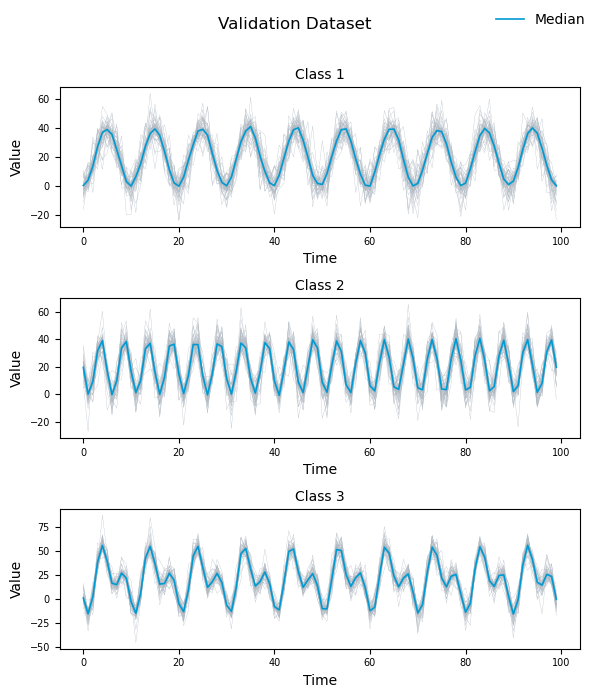

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 7))
for i in range(3):
    axs[i].plot(validation_dataset[validation_dataset[f"y_{i + 1}"] == 1].iloc[:, 5:].transpose().values, color="#AFB8C1", lw=0.2, alpha=1)
    axs[i].plot(validation_dataset[validation_dataset[f"y_{i + 1}"] == 1].iloc[:, 5:].transpose().median(axis=1).values, color="#009ad3", lw=1.2, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Validation Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

### C. Upload datasets to Amazon S3

In [14]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False),
    bucket=bucket,
    key="data/training/train.csv"
)

In [15]:
training_data

's3://sagemaker-eu-west-1-661670223746/data/training/train.csv'

In [16]:
validation_data = sagemaker_session.upload_string_as_file_body(
    body=validation_dataset.to_csv(index=False),
    bucket=bucket,
    key="data/training/valid.csv"
)

In [17]:
validation_data

's3://sagemaker-eu-west-1-661670223746/data/training/valid.csv'

## 3. Train a machine learning model

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to train a machine learning model. 

### 3.1 Set up environment

In [18]:
role = sagemaker.get_execution_role()

### 3.2 Train a model

You can find more information about the model's hyperparameters in the **Hyperparameters** section of the algorithm listing page.

In [19]:
hyperparameters = {
    "filters": 8,
    "depth": 6,
    "models": 3,
    "batch-size": 32,
    "lr": 0.0001,
    "epochs": 5,
    "task": "multiclass"
}

For information on creating an `Estimator` object, see the [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html).

In [20]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="inception-training",
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
)

estimator.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating training-job with name: inception-training-2024-08-13-17-39-24-894


2024-08-13 17:39:25 Starting - Starting the training job...
2024-08-13 17:39:41 Starting - Preparing the instances for training...
2024-08-13 17:40:17 Downloading - Downloading the training image..................
2024-08-13 17:43:13 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2024-08-13 17:43:31,835 sagemaker-training-toolkit INFO  

See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

You can use the model artifacts generated by the training job to continue training the model on the same dataset or to fine-tune the model on a different dataset (**incremental training**). You still need to provide all the hyperparameters to the estimator, but the training job will only use the learning rate, batch size and number of epochs, while it will overwrite all the other hyperparameters with the ones saved in the pre-trained model checkpoint.

In [21]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    model_uri=f's3://{bucket}/{estimator.latest_training_job.name}/output/model.tar.gz',
    algorithm_arn=algo_arn,
    base_job_name="inception-fine-tuning",
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters
)

estimator.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating training-job with name: inception-fine-tuning-2024-08-13-17-44-37-730


2024-08-13 17:44:37 Starting - Starting the training job...
2024-08-13 17:44:52 Starting - Preparing the instances for training...
2024-08-13 17:45:32 Downloading - Downloading the training image..................
2024-08-13 17:48:29 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2024-08-13 17:48:47,374 sagemaker-training-toolkit INFO  

## 4. Deploy model and verify results

Now you can deploy the model for performing real-time inference.

In [22]:
serializer = sagemaker.serializers.CSVSerializer(content_type="text/csv")
deserializer = sagemaker.base_deserializers.PandasDeserializer(accept="text/csv")

### A. Deploy trained model

In [23]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    model_name=f"inception-model-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
    endpoint_name=f"inception-endpoint-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
)

INFO:sagemaker:Creating model package with name: inception-model-2024-08-13-17-49-50-557350


.........

INFO:sagemaker:Creating model with name: inception-model-2024-08-13-17-49-50-557350


INFO:sagemaker:Creating endpoint-config with name inception-endpoint-2024-08-13-17-49-50-557381
INFO:sagemaker:Creating endpoint with name inception-endpoint-2024-08-13-17-49-50-557381


---------!

Once the endpoint is in service, you can perform real-time inference.

### B. Create input payload

The inference algorithm takes as input a CSV file containing the time series values. 
The column names of the time series values should start with `"x"` (e.g. `"x1"`, `"x2"`, ...).

The CSV file should contain unique sample identifiers in a column named `"sample"`, and unique feature identifiers in a column named `"feature"`.
The feature identifiers are used to determine the different dimensions of multivariate time series. 
When using univariate time series, the feature identifiers can be set to a constant value. 
The feature identifiers used for inference should match the ones used for training.

All the time series should have the same length and the same number of dimensions, and should not contain missing values.
The time series are scaled internally by the algorithm, there is no need to scale the time series beforehand.

**Test dataset:**

In [24]:
test_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/inception-time-sagemaker/master/data/inference/input/test_data.csv",
    index_col=None
)

In [25]:
test_dataset.head(10)

,sample,feature,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
0,1,1,-1.197587,-1.101539,13.195641,27.746487,39.731572,40.552427,30.403431,27.441094,...,8.381078,10.889648,28.635494,33.273228,41.548277,44.982535,27.717128,15.220179,-4.238753,-10.519835
1,1,2,-3.403345,3.826090,24.744240,34.984865,38.185972,52.447169,29.215948,26.748044,...,3.472020,2.038584,23.833026,37.234324,46.642084,25.277087,30.934210,13.201640,2.175132,-22.259332
2,1,3,11.428013,4.158511,12.003529,28.490081,37.135306,44.659069,35.035586,25.372676,...,-1.290320,15.249586,25.521965,36.236810,39.351797,40.956972,25.904862,16.329038,1.984364,-4.019164
3,1,4,0.589305,1.596616,17.406567,32.185410,36.557795,47.074674,31.100490,33.609066,...,3.441606,12.880587,28.373153,10.424306,38.725575,40.335716,26.844843,21.703602,5.084200,-0.132590
4,1,5,-1.584229,24.219888,15.634381,26.968459,37.157542,44.693076,37.787975,28.292575,...,2.231766,12.524666,39.119596,39.845437,46.394450,39.102505,33.995239,6.926868,-1.558114,7.594939
5,2,1,-2.951257,-13.630258,-0.091758,35.345531,45.928694,39.826932,14.186456,23.448971,...,-16.941419,-3.181645,37.640457,52.605675,36.696986,21.541004,16.282077,25.485585,11.686681,1.881178
6,2,2,-0.523096,-8.463172,8.816208,45.402711,56.221992,37.772506,16.157508,13.955756,...,-29.555835,-2.676574,37.790822,55.992591,43.705627,13.704209,7.159543,16.431363,20.881186,5.691126
7,2,3,0.543556,-23.127225,18.055801,41.678118,53.775384,33.036505,20.048284,16.768340,...,-12.786186,18.271215,29.785254,58.719151,42.586348,22.481224,11.371183,32.502420,22.068152,-1.804677
8,2,4,0.004957,-15.141888,-7.169284,35.046075,52.294390,38.256633,16.019363,12.146068,...,-14.965436,2.404721,32.029540,54.465655,35.833275,11.695283,5.345844,15.737410,18.581751,-2.768447
9,2,5,1.975800,-11.094991,5.508976,37.111279,51.665356,36.654897,17.631319,6.697911,...,-4.122671,3.404601,37.972814,50.390359,46.667067,9.448842,19.879313,37.067380,23.736045,6.464350


In [26]:
test_dataset.shape

(150, 102)

In [27]:
test_dataset["sample"].nunique()

30

In [28]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False),
    bucket=bucket,
    key="data/inference/input/test_data.csv"
)

In [29]:
test_data

's3://sagemaker-eu-west-1-661670223746/data/inference/input/test_data.csv'

Given that the test dataset used in this experiment is relatively small, we invoke the endpoint using all the data.

In [30]:
payload = test_dataset.to_csv(index=False)

### C. Perform real-time inference

In [31]:
response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType="text/csv",
    Body=payload
)

real_time_predictions = deserializer.deserialize(response["Body"], content_type="text/csv")

In [32]:
response

{'ResponseMetadata': {'RequestId': '16c2d8a9-4a8c-4cfa-8baa-c005aa809231',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '16c2d8a9-4a8c-4cfa-8baa-c005aa809231',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Tue, 13 Aug 2024 17:55:39 GMT',
   'content-type': 'application/json',
   'content-length': '1275',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f272642a2c0>}

In [33]:
real_time_results = sagemaker_session.upload_string_as_file_body(
    body=real_time_predictions.to_csv(index=False),
    bucket=bucket,
    key="data/inference/output/real-time/real_time_predictions.csv"
)

In [34]:
real_time_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/real-time/real_time_predictions.csv'

### D. Visualize output

The inference algorithm outputs the predicted class labels and the predicted class probabilities, which are returned in CSV format.

In [35]:
real_time_predictions.head(10)

,sample,y_1,y_2,y_3,p_1,p_2,p_3
0,1,1,0,0,0.835666,0.073406,0.090928
1,2,0,0,1,0.221922,0.346087,0.431991
2,3,1,0,0,0.908107,0.043813,0.048080
3,4,0,1,0,0.135291,0.737833,0.126876
4,5,0,1,0,0.133081,0.739392,0.127527
5,6,0,1,0,0.131100,0.733551,0.135350
6,7,1,0,0,0.862478,0.062157,0.075365
7,8,0,0,1,0.219224,0.287697,0.493080
8,9,1,0,0,0.892565,0.051292,0.056143
9,10,0,0,1,0.247587,0.316604,0.435809


In [36]:
real_time_predictions.shape

(30, 7)

In [37]:
real_time_predictions["sample"].nunique()

30

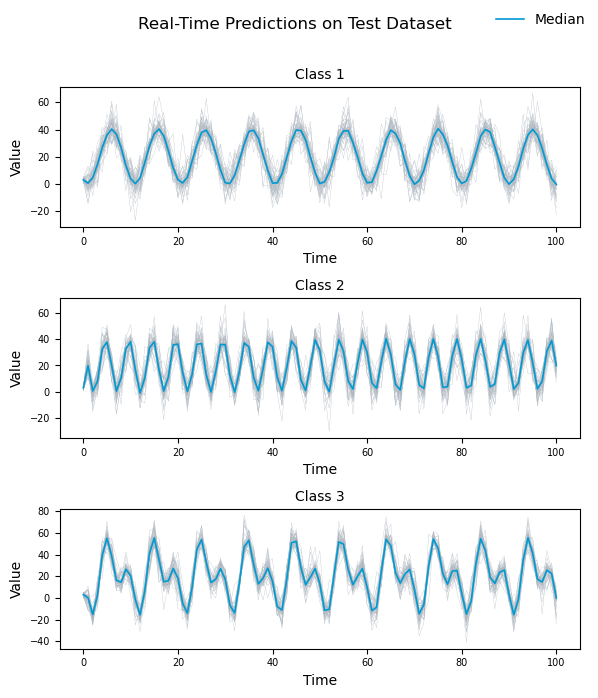

In [38]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 7))
for i in range(3):
    axs[i].plot(test_dataset[test_dataset["sample"].isin(real_time_predictions.loc[real_time_predictions[f"y_{i + 1}"] == 1, "sample"])].iloc[:, 1:].transpose().values, color="#AFB8C1", lw=0.2, alpha=1)
    axs[i].plot(test_dataset[test_dataset["sample"].isin(real_time_predictions.loc[real_time_predictions[f"y_{i + 1}"] == 1, "sample"])].iloc[:, 1:].transpose().median(axis=1).values, color="#009ad3", lw=1.2, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Real-Time Predictions on Test Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

### E. Calculate relevant metrics

In this section we assess the model's classification performance against the ground truth test labels. We use `scikit-learn`'s [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for calculating the main classification metrics for each class. 

In [39]:
test_labels = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/inception-time-sagemaker/master/data/inference/output/test_labels.csv",
    index_col=None
)

In [40]:
test_labels.head()

,sample,y_1,y_2,y_3
0,1,1.0,0.0,0.0
1,2,0.0,0.0,1.0
2,3,1.0,0.0,0.0
3,4,0.0,1.0,0.0
4,5,0.0,1.0,0.0


In [41]:
test_labels.shape

(30, 4)

In [42]:
test_labels["sample"].nunique()

30

In [43]:
metrics = pd.DataFrame(data=classification_report(y_true=test_labels.iloc[:, 1:], y_pred=real_time_predictions.iloc[:, 1:4], output_dict=True))

In [44]:
metrics

,0,1,2,micro avg,macro avg,weighted avg,samples avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0
support,10.0,10.0,10.0,30.0,30.0,30.0,30.0


If [Amazon SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) supports the type of problem you are trying to solve using this algorithm, use the following examples to add Model Monitor support to your product.
For sample code to enable and monitor the model, see following notebooks:
1. [Enable Amazon SageMaker Model Monitor](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/enable_model_monitor/SageMaker-Enable-Model-Monitor.ipynb)
2. [Amazon SageMaker Model Monitor - visualizing monitoring results](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.ipynb)

### F. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the same to avoid being charged.

In [45]:
predictor.delete_model()
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting model with name: inception-model-2024-08-13-17-49-50-557350
INFO:sagemaker:Deleting endpoint configuration with name: inception-endpoint-2024-08-13-17-49-50-557381
INFO:sagemaker:Deleting endpoint with name: inception-endpoint-2024-08-13-17-49-50-557381


Since this is an experiment, you do not need to run a hyperparameter tuning job. However, if you would like to see how to tune a model trained using a third-party algorithm with Amazon SageMaker's hyperparameter tuning functionality, you can run the optional tuning step.

## 5. Tune your model! (optional)

### A. Tuning Guidelines

The model has the following hyperparameters:
- `filters`: `int`. The number of filters of each model.
- `depth`: `int`. The number of blocks of each model.
- `models`: `int`. The number of models.
- `lr`: `float`. The learning rate used for training.
- `batch-size`: `int`. The batch size used for training.
- `epochs`: `int`. The number of training epochs.
- `task`: `str`. The type of classification task, either `"binary"`, `"multiclass"` or `"multilabel"`.

All the hyperparameters are tunable, excluding the type of classification task, which needs to be defined beforehand.

### B. Define Tuning configuration

In [46]:
hyperparameter_ranges = {
    "filters": sagemaker.parameter.CategoricalParameter([4, 8, 16, 32]),
    "depth": sagemaker.parameter.CategoricalParameter([3, 6]),
    "models": sagemaker.parameter.IntegerParameter(2, 10),
    "lr": sagemaker.parameter.ContinuousParameter(0.0001, 0.001),
    "batch-size": sagemaker.parameter.CategoricalParameter([16, 32, 64]),
    "epochs": sagemaker.parameter.IntegerParameter(1, 10),
}

We use the validation accuracy as the objective to be maximized.

In [47]:
objective_metric_name = "valid_accuracy"

In [48]:
objective_type = "Maximize"

### C. Run a model tuning job

Make sure to detach the pre-trained model before tuning, otherwise the algorithm will keep using the same hyperparameters with the exception of the batch size, learning rate and number of epochs.

In [49]:
estimator.model_uri = None

In the interest of time, we run the tuner only for a few iterations. 

In [50]:
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator=estimator,
    base_tuning_job_name="inception-tuning",
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=4,
    max_parallel_jobs=4,
    random_seed=100,
)

In [51]:
tuner.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating hyperparameter tuning job with name: inception-tuning-240813-1755


.................................................................!


In [52]:
tuner.analytics().dataframe().sort_values(by="FinalObjectiveValue", ascending=False, ignore_index=True)

,batch-size,depth,epochs,filters,lr,models,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,16.0,6.0,6.0,8.0,0.000907,2.0,inception-tuning-240813-1755-003-6bd82e27,Completed,1.000000,2024-08-13 17:56:25+00:00,2024-08-13 18:00:25+00:00,240.0
1,16.0,6.0,3.0,32.0,0.000727,9.0,inception-tuning-240813-1755-002-12d427e9,Completed,1.000000,2024-08-13 17:56:28+00:00,2024-08-13 18:00:58+00:00,270.0
2,16.0,3.0,9.0,16.0,0.000991,3.0,inception-tuning-240813-1755-001-c720a927,Completed,1.000000,2024-08-13 17:56:21+00:00,2024-08-13 18:00:31+00:00,250.0
3,64.0,3.0,3.0,16.0,0.000838,10.0,inception-tuning-240813-1755-004-cf796847,Completed,0.777778,2024-08-13 17:56:31+00:00,2024-08-13 18:00:26+00:00,235.0


In [53]:
tuning_job_result = sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.name
)

In [54]:
print("Best hyperparameters:")
tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

Best hyperparameters:


{'batch-size': '16',
 'depth': '3',
 'epochs': '9',
 'filters': '16',
 'lr': '0.0009906083505233862',
 'models': '3'}

In [55]:
print("Best score:")
tuning_job_result["BestTrainingJob"]["FinalHyperParameterTuningJobObjectiveMetric"]["Value"]

Best score:


1.0

Once you have completed a tuning job (or even while the job is still running), you can [clone and use this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) to analyze the results to understand how each hyperparameter effects the quality of the model.

## 6. Perform Batch inference

In this section, you will perform batch inference.

In [56]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
)

INFO:sagemaker:Creating model package with name: inception-time-v1-8-2024-08-13-18-01-18-886


.........

INFO:sagemaker:Creating model with name: inception-time-v1-8-2024-08-13-18-01-18-2024-08-13-18-02-04-354


In [57]:
transformer.base_transform_job_name = "inception-transform"

In [58]:
transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating transform job with name: inception-transform-2024-08-13-18-02-05-285


2024-08-13T18:10:12,349 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2024-08-13T18:10:12,351 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2024-08-13T18:10:12,417 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2024-08-13T18:10:12,513 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.11.0
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Infe

In [59]:
batch_predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/test_data.csv.out"
)

batch_predictions = pd.read_csv(io.StringIO(batch_predictions))

In [60]:
batch_predictions.head()

,sample,y_1,y_2,y_3,p_1,p_2,p_3
0,1,1,0,0,0.835666,0.073406,0.090928
1,2,0,0,1,0.221922,0.346087,0.431991
2,3,1,0,0,0.908107,0.043813,0.048080
3,4,0,1,0,0.135291,0.737833,0.126876
4,5,0,1,0,0.133081,0.739392,0.127527


In [61]:
batch_predictions.shape

(30, 7)

In [62]:
batch_predictions["sample"].nunique()

30

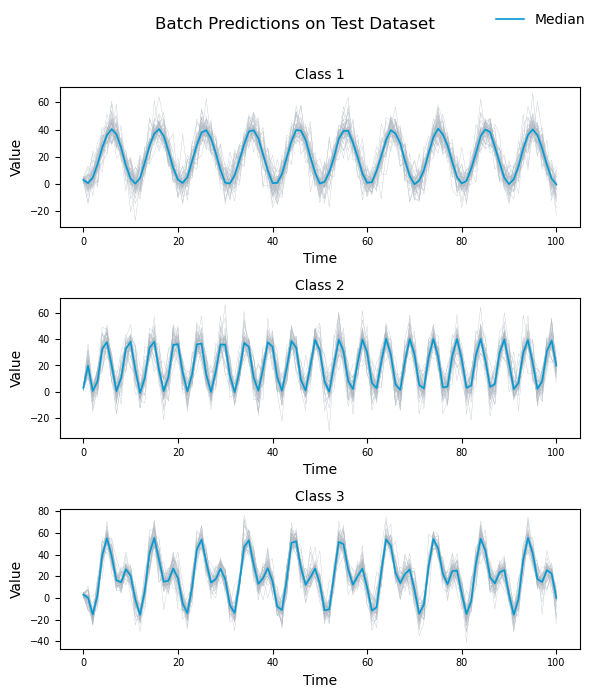

In [63]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 7))
for i in range(3):
    axs[i].plot(test_dataset[test_dataset["sample"].isin(batch_predictions.loc[batch_predictions[f"y_{i + 1}"] == 1, "sample"])].iloc[:, 1:].transpose().values, color="#AFB8C1", lw=0.2, alpha=1)
    axs[i].plot(test_dataset[test_dataset["sample"].isin(batch_predictions.loc[batch_predictions[f"y_{i + 1}"] == 1, "sample"])].iloc[:, 1:].transpose().median(axis=1).values, color="#009ad3", lw=1.2, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Batch Predictions on Test Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

In [64]:
np.all(batch_predictions.values == real_time_predictions.values)

True

In [65]:
batch_results = sagemaker_session.upload_string_as_file_body(
    body=batch_predictions.to_csv(index=False),
    bucket=bucket,
    key="data/inference/output/batch/batch_predictions.csv"
)

In [66]:
batch_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/batch/batch_predictions.csv'

## 7. Clean-up

### A. Delete the model

In [67]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: inception-time-v1-8-2024-08-13-18-01-18-2024-08-13-18-02-04-354


### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

